Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


Epoch [1/5], Loss: 0.1035
Epoch [2/5], Loss: 0.0518
Epoch [3/5], Loss: 0.0450
Epoch [4/5], Loss: 0.0427
Epoch [5/5], Loss: 0.0410
Test Accuracy: 99.03%


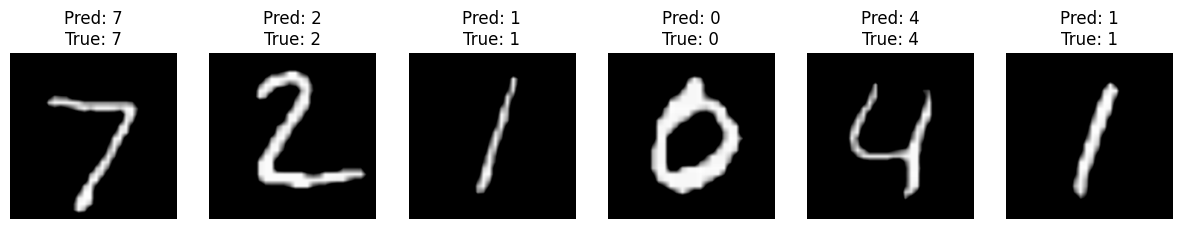

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformation: Resize MNIST images to 224x224 and convert grayscale to RGB
transform = transforms.Compose([
    transforms.Resize(224),  # VGG16 expects 224x224 images
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load pre-trained VGG16 model
vgg = models.vgg16(pretrained=True)

# Freeze all convolutional layers (feature extractor)
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace the classifier for MNIST (10 output classes)
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)  # Output layer for 10 classes
)

# Move model to device
vgg = vgg.to(device)

# Define loss function and optimizer (only update classifier)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vgg(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation on the test dataset
vgg.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Visualize some predictions
def plot_predictions(model, data_loader):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.set_title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
        ax.axis('off')
    plt.show()

# Plot predictions
plot_predictions(vgg, test_loader)
